# Preprocessing and Building the Train/Test/Val Splits
This script normalizes the data and builds a tensorflow record.

In [1]:
from PIL import Image
import numpy as np
import tensorflow as tf
import pathlib
import matplotlib.pyplot as plt
import re
import random

AUTOTUNE = tf.data.experimental.AUTOTUNE
print("Executing Eagerly?", tf.executing_eagerly())

Executing Eagerly? True


In [2]:
tfrecords_fh = 'rope_depth_3d_%s.tfrecords'
depth_fh = '/scr2/varun/projs/data_intersection/%04d_depth.png'
position_fh = '/scr2/varun/projs/data_intersection/%04d.txt'
intersect_fh = '/scr2/varun/projs/data_intersection/%04d_intersect.txt'

data_dir = '/scr2/varun/projs/data_intersection/'
data_root = pathlib.Path(data_dir)

size = 10000

depth_pre = [None] * size
position_pre = [None] * size
intersect_pre = [None] * size

for item in data_root.iterdir():
    handle = str(item)
    if "mod" not in handle:
        idx = int(handle.split("/")[-1][:4])
        if "depth" in handle:
            depth_pre[idx] = handle
        elif "intersect.txt" in handle:
            intersect_pre[idx] = handle
        elif ".txt" in handle:
            position_pre[idx] = handle

In [3]:
to_sample = list(range(size))

random.seed(231)
random.shuffle(to_sample)

depth = [depth_pre[i] for i in to_sample]
position = [position_pre[i] for i in to_sample]
intersect = [intersect_pre[i] for i in to_sample]

train_idx, test_idx, val_idx = [0.9 * size, 0.05 * size, 0.05 * size]
val_idx += (train_idx + test_idx)
test_idx += train_idx

print(train_idx, test_idx, val_idx)
print(depth[:5])
print(position[:5])
print(intersect[:5])

9000.0 9500.0 10000.0
['/scr2/varun/projs/data_intersection/7762_depth.png', '/scr2/varun/projs/data_intersection/7276_depth.png', '/scr2/varun/projs/data_intersection/7106_depth.png', '/scr2/varun/projs/data_intersection/7044_depth.png', '/scr2/varun/projs/data_intersection/8180_depth.png']
['/scr2/varun/projs/data_intersection/7762.txt', '/scr2/varun/projs/data_intersection/7276.txt', '/scr2/varun/projs/data_intersection/7106.txt', '/scr2/varun/projs/data_intersection/7044.txt', '/scr2/varun/projs/data_intersection/8180.txt']
['/scr2/varun/projs/data_intersection/7762_intersect.txt', '/scr2/varun/projs/data_intersection/7276_intersect.txt', '/scr2/varun/projs/data_intersection/7106_intersect.txt', '/scr2/varun/projs/data_intersection/7044_intersect.txt', '/scr2/varun/projs/data_intersection/8180_intersect.txt']


In [4]:
def preprocess_image(image):
    image = tf.image.decode_png(image, channels=3)
    image = tf.cast(image, tf.float32)
#     image = tf.image.resize(img_tensor, [224, 224])   # this would be if i wanted to resize
    image /= 255.0
    return image

def load_and_preprocess(path, path2, path3):
    image = tf.io.read_file(path)
    return preprocess_image(image), path2, path3

<br/>
Just playing around with the data. Getting a feel for what the depth and numpy arrays are like.

Min Value: 102
Max Value: 110


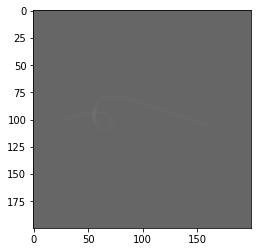

In [5]:
sample_num = 254

img_raw = tf.io.read_file(depth[sample_num])
img_tensor = tf.image.decode_png(img_raw, channels=3)
# img_tensor = tf.image.resize(img_tensor, [224, 224])  # This would be if i wanted to resize

print("Min Value:", img_tensor.numpy().min())
print("Max Value:", img_tensor.numpy().max())

img_tensor = tf.cast(img_tensor, tf.float32)
img_tensor /= 255.0

plt.imshow(img_tensor)
plt.grid(False)

In [6]:
pos_raw = tf.io.read_file(position[sample_num])
pos_raw = re.split(' |\n', pos_raw.numpy().decode("utf-8"))
pos_raw = pos_raw[:-1]
pos_raw = [float(pos) for pos in pos_raw]
pos_tensor = tf.convert_to_tensor(pos_raw, tf.float32)
pos_tensor = tf.reshape(pos_tensor, [int(len(pos_raw)/3), 3])
pos_tensor = tf.transpose(pos_tensor[:, :2])       # choosing to get rid of the height.

intersect_np = np.loadtxt(intersect[sample_num])
intersect_tensor = tf.convert_to_tensor(intersect_np.flatten(), tf.float32)

if pos_tensor[0, 0] > pos_tensor[0, -1]:
    print("i flipped")
    pos_tensor = pos_tensor[:, ::-1]
    intersect_tensor = intersect_tensor[::-1]

### Building the Dataset and Saving It

Make sure to first compute the position dataset then the intersection dataset. We need to track if we flipped the position dataset. Any change should be reflected in the intersection dataset.

In [7]:
def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def _intList_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=value))

def _floatList_feature(value):
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))

def generate_example(depth_path, position_path, intersect_path):
    depth_img = Image.open(depth_path)
    depth_img = depth_img.resize((224, 224), resample=Image.LANCZOS)    # upscale to input into VGG
    depth_img = np.array(depth_img)[:, :, :3]                           # removes alpha channel
    
    pos_arr = np.loadtxt(position_path)
    pos_arr = pos_arr[:, :2].T.astype(np.float32)
    
    inter_arr = np.loadtxt(intersect_path)
    inter_arr = inter_arr.flatten().astype(np.int64)
    
    has_inter = 1 if inter_arr[inter_arr != 0].size > 0 else 0
    
    if pos_arr[0, 0] > pos_arr[0, -1]:
        pos_arr = pos_arr[:, ::-1]
        inter_arr = inter_arr[::-1]
        print("flipped for:", position_path, intersect_path)
    
    record = tf.train.Example(features=tf.train.Features(feature={
        'height' : _int64_feature(depth_img.shape[0]),
        'width' : _int64_feature(depth_img.shape[1]),
        'image_raw' : _bytes_feature(depth_img.tostring()),
        'position' : _floatList_feature(pos_arr.flatten().tolist()),
        'intersect' : _intList_feature(inter_arr.tolist()),
        'has_intersection' : _int64_feature(has_inter)
    }))
    
    return record

In [8]:
train_record_file = 'assets/non-temporal/train-3d.tfrec'
test_record_file = 'assets/non-temporal/test-3d.tfrec'
val_record_file = 'assets/non-temporal/val-3d.tfrec'

with tf.io.TFRecordWriter(train_record_file) as train_writer:
    with tf.io.TFRecordWriter(test_record_file) as test_writer:
        with tf.io.TFRecordWriter(val_record_file) as val_writer:
            for ind, (dep, pos, inter) in enumerate(zip(depth, position, intersect)):
                tf_example = generate_example(dep, pos, inter)
                
                if ind < train_idx:
                    train_writer.write(tf_example.SerializeToString())
                elif ind < test_idx:
                    test_writer.write(tf_example.SerializeToString())
                else:
                    val_writer.write(tf_example.SerializeToString())